### Recreate figures from Khan et al. (2015)

In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from matplotlib.offsetbox import AnchoredText
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Path to data
path_to_ukca = Path.cwd().parent / 'raw'
# Path to figures
path_to_figs = Path.cwd().parent.parent.parent / 'results' / 'xojn' / 'Khan2015-like'
path_to_figs.mkdir(exist_ok=True)

In [3]:
# Global variables
JOBS = {'BASE OLD':'xojnd',
        'BASE'    :'xojng',
        'CHEM'    :'xojnh',
        'MARI'    :'xojni',
        'FIRE'    :'xojnc',
        'FULL'    :'xojnl',
        'ORIG'    :'xolnb',
        'UPDT'    :'xolna'}
VARIABLES = {'molar_mass': {'o3':47.997, 'no':30.006, 'no2':46.006, 'hono':47.013, 'ho2no2':79.01224, 'hno3':63.012, 'n2o5':108.01, 
                            'pan':121.0489, 'ppan':135.0755,
                            'meono2':77.0394, 'etono2':91.0660, 'nprono2':105.0926, 'iprono2':105.0926,
                            'ch4':16.0425, 'c2h6':30.0690},
             'latex': {'o3':'$O_3$', 'no':'NO', 'no2':'$NO_2$', 'hono':'HONO', 'ho2no2':'$HO_2NO_2$', 'hno3':'$HNO_3$', 'n2o5':'N_2O_5', 
                       'pan':'PAN', 'ppan':'PPN', 
                       'nox':'$NO_x$', 'noy':'$NO_y$', 
                       'meono2':'$MeONO_2$', 'etono2':'$EtONO_2$', 'nprono2':'$nPrONO_2$', 'iprono2':'$iPrONO_2$', 'prono2':'$PrONO_2$',
                       'ch4':'$CH_4$', 'c2h6':'$C_2H_6$'}}
M_air = 28.97 # molar mass of dry air [g mol-1]

In [4]:
# Switches
exp = 'CHEM'
savefig = False

job = JOBS[exp]

#### Annual surface mean (like Figure 1 in Khan et al. (2015))

In [5]:
# This cell's credit: https://github.com/dennissergeev
from iris.analysis.cartography import wrap_lons
from iris.util import is_regular

def _is_longitude_global(lon_points):
    """Return True if array of longitudes covers the whole sphere."""
    dx = np.diff(lon_points)[0]  # assume regular grid
    case_0_360 = ((lon_points[0] - dx) <= 0) and ((lon_points[-1] + dx) >= 360)
    case_pm180 = ((lon_points[0] - dx) <= -180) and ((lon_points[-1] + dx) >= 180)
    return case_0_360 or case_pm180

def roll_cube_e2w(cube_in, coord_name="longitude", inplace=False):
    """
    Take a cube which goes longitude 0-360 back to -180-180.
    Works with global model output, and in some cases for regional.
    """
    if inplace:
        cube = cube_in
    else:
        cube = cube_in.copy()
    xcoord = cube.coord(coord_name)
    if (xcoord.points >= 0.0).all():
        assert is_regular(xcoord), "Operation is only valid for a regularly spaced coordinate."
        if _is_longitude_global(xcoord.points):
            # Shift data symmetrically only when dealing with global cubes
            cube.data = np.roll(cube.data, len(xcoord.points) // 2, axis=-1)

        if xcoord.has_bounds():
            bounds = np.sort(wrap_lons(xcoord.bounds, -180, 360), axis=0)  # + subtract
        else:
            bounds = None
        cube.replace_coord(
            xcoord.copy(points=np.sort(wrap_lons(xcoord.points, -180, 360)), bounds=bounds)
        )
    else:
        # Nothing to do, the cube is already centered on 0 longitude
        # unless there is something wrong with longitude
        msg = f"Incorrect {coord_name} values: from {xcoord.points.min()} to {xcoord.points.max()}"
        assert ((xcoord.points >= -180.0) & (xcoord.points <= 180.0)).all(), msg
    if not inplace:
        return cube

In [6]:
# Read data
meono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_meono2.nc'), 'meono2')*(M_air/VARIABLES['molar_mass']['meono2'])*1e12
etono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_etono2.nc'), 'etono2')*(M_air/VARIABLES['molar_mass']['etono2'])*1e12
nprono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_nprono2.nc'), 'nprono2')*(M_air/VARIABLES['molar_mass']['nprono2'])*1e12
iprono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_iprono2.nc'), 'iprono2')*(M_air/VARIABLES['molar_mass']['iprono2'])*1e12
# Remove the first 2 years as a spin up
meono2 = meono2[24::,...]
etono2 = etono2[24::,...]
nprono2 = nprono2[24::,...]
iprono2 = iprono2[24::,...]
# Add year coordinate
for icb in [meono2, etono2, nprono2, iprono2]:    
    iris.coord_categorisation.add_season_year(icb, 'time', name='year')
# Define constraints
srf = iris.Constraint(level_height=19.998281)
# Extract and average data
meono2_srf_ann = meono2.extract(srf).collapsed(['year'], iris.analysis.MEAN)
etono2_srf_ann = etono2.extract(srf).collapsed(['year'], iris.analysis.MEAN)
nprono2_srf_ann = nprono2.extract(srf).collapsed(['year'], iris.analysis.MEAN)
iprono2_srf_ann = iprono2.extract(srf).collapsed(['year'], iris.analysis.MEAN)
# Roll the data to be able to plot contour lines properly
r_meono2_srf_ann = roll_cube_e2w(meono2_srf_ann)
r_etono2_srf_ann = roll_cube_e2w(etono2_srf_ann)
r_nprono2_srf_ann = roll_cube_e2w(nprono2_srf_ann)
r_iprono2_srf_ann = roll_cube_e2w(iprono2_srf_ann)
lons = r_meono2_srf_ann.coord('longitude').points
lats = r_meono2_srf_ann.coord('latitude').points
# Add a cyclic point
c_r_meono2_srf_ann, c_lons = cartopy.util.add_cyclic_point(r_meono2_srf_ann.data, coord=lons)
c_r_etono2_srf_ann = cartopy.util.add_cyclic_point(r_etono2_srf_ann.data)
c_r_nprono2_srf_ann = cartopy.util.add_cyclic_point(r_nprono2_srf_ann.data)
c_r_iprono2_srf_ann = cartopy.util.add_cyclic_point(r_iprono2_srf_ann.data)

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('rainbow')
new_cmap = truncate_colormap(cmap, 0.1, 1)

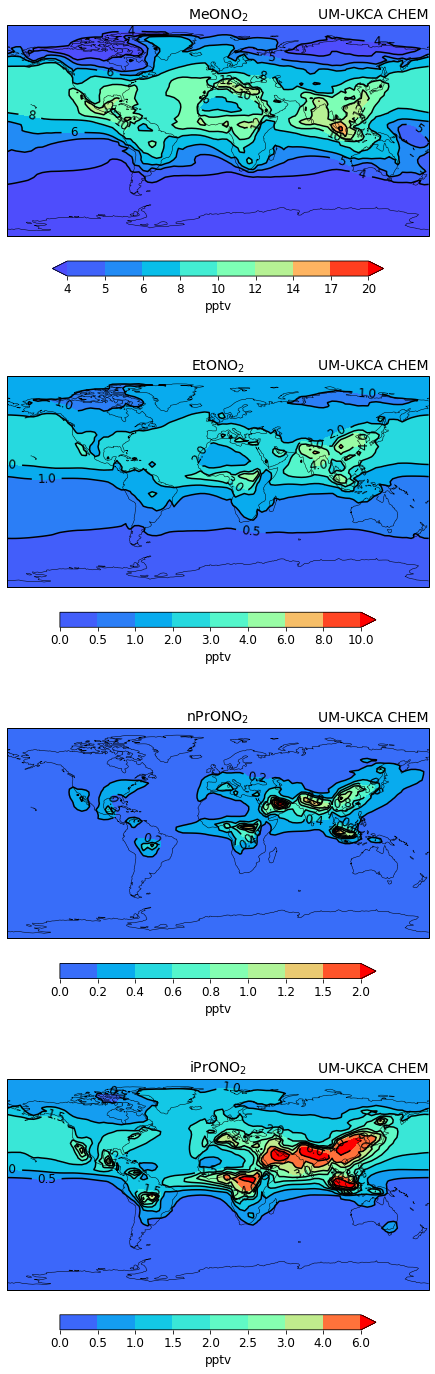

In [31]:
# Aligned vertically
path_to_thesis = Path.home() / 'UEA' / 'PhD' / 'thesis' / 'chapters' / 'ch4' / 'figures'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 12
cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap=new_cmap, extend='max')
cr_kwargs = dict(transform=ccrs.PlateCarree(), colors='k')
# Plot annual surface mean 12,8
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,24), facecolor='w', 
                       subplot_kw=dict(projection=ccrs.PlateCarree()), 
                       gridspec_kw=dict(hspace=0.4, wspace=0.05))

cf00 = ax[0].contourf(c_lons, lats, c_r_meono2_srf_ann.data, levels=[4,5,6,8,10,12,14,17,20], transform=ccrs.PlateCarree(), cmap=new_cmap, extend='both')
cr00 = ax[0].contour(c_lons, lats, c_r_meono2_srf_ann.data, levels=[4,5,6,8,10,12,14,17,20], **cr_kwargs)
cf01 = ax[1].contourf(c_lons, lats, c_r_etono2_srf_ann.data, levels=[0,0.5,1,2,3,4,6,8,10], **cf_kwargs)
cr01 = ax[1].contour(c_lons, lats, c_r_etono2_srf_ann.data, levels=[0,0.5,1,2,3,4,6,8,10], **cr_kwargs) 
cf10 = ax[2].contourf(c_lons, lats, c_r_nprono2_srf_ann.data, levels=[0,0.2,0.4,0.6,0.8,1,1.2,1.5,2], **cf_kwargs)
cr10 = ax[2].contour(c_lons, lats, c_r_nprono2_srf_ann.data, levels=[0,0.2,0.4,0.6,0.8,1,1.2,1.5,2], **cr_kwargs)
cf11 = ax[3].contourf(c_lons, lats, c_r_iprono2_srf_ann.data, levels=[0,0.5,1,1.5,2,2.5,3,4,6], **cf_kwargs)
cr11 = ax[3].contour(c_lons, lats, c_r_iprono2_srf_ann.data, levels=[0,0.5,1,1.5,2,2.5,3,4,6], **cr_kwargs)

cb00 = fig.colorbar(cf00, ax=ax[0], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
cb01 = fig.colorbar(cf01, ax=ax[1], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
cb10 = fig.colorbar(cf10, ax=ax[2], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
cb11 = fig.colorbar(cf11, ax=ax[3], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
ax[0].clabel(cr00, fmt='%2i', colors='k')
ax[1].clabel(cr01, fmt='%1.1f', colors='k')
ax[2].clabel(cr10, fmt='%1.1f', colors='k')
ax[3].clabel(cr11, fmt='%1.1f', colors='k')

# fig.suptitle(f'UM-UKCA {exp}', weight='bold', y=0.905)
ax[0].set_title(VARIABLES['latex']['meono2'], loc='center')
ax[1].set_title(VARIABLES['latex']['etono2'], loc='center')
ax[2].set_title(VARIABLES['latex']['nprono2'], loc='center')
ax[3].set_title(VARIABLES['latex']['iprono2'], loc='center')
for iax in ax.flatten(): 
    iax.coastlines(linewidth=0.5)
    iax.set_title(f'UM-UKCA {exp}', loc='right')
if savefig: fig.savefig(path_to_thesis / f'Khan2015-like_{exp.lower()}_srf_ann_vert_align.png', bbox_inches='tight', dpi=200)

In [ ]:
break

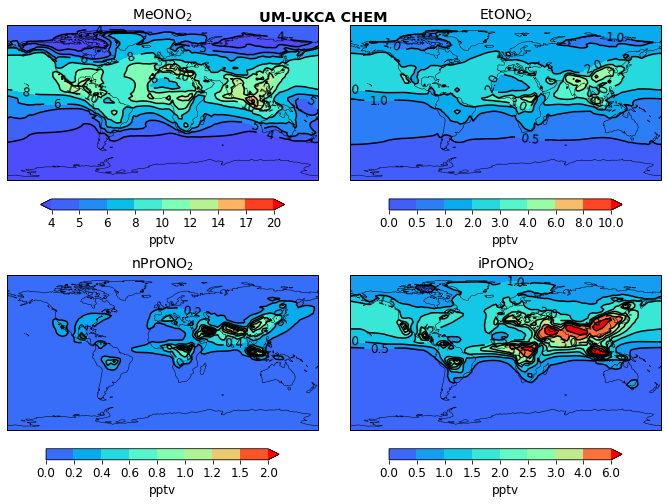

In [8]:
# Aligned side by side
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 12
cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap=new_cmap, extend='max')
cr_kwargs = dict(transform=ccrs.PlateCarree(), colors='k')
# Plot annual surface mean
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), facecolor='w', 
                       subplot_kw=dict(projection=ccrs.PlateCarree()), gridspec_kw=dict(hspace=0.35, wspace=0.05))

cf00 = ax[0,0].contourf(c_lons, lats, c_r_meono2_srf_ann.data, levels=[4,5,6,8,10,12,14,17,20], transform=ccrs.PlateCarree(), cmap=new_cmap, extend='both')
cr00 = ax[0,0].contour(c_lons, lats, c_r_meono2_srf_ann.data, levels=[4,5,6,8,10,12,14,17,20], **cr_kwargs)
cf01 = ax[0,1].contourf(c_lons, lats, c_r_etono2_srf_ann.data, levels=[0,0.5,1,2,3,4,6,8,10], **cf_kwargs)
cr01 = ax[0,1].contour(c_lons, lats, c_r_etono2_srf_ann.data, levels=[0,0.5,1,2,3,4,6,8,10], **cr_kwargs) 
cf10 = ax[1,0].contourf(c_lons, lats, c_r_nprono2_srf_ann.data, levels=[0,0.2,0.4,0.6,0.8,1,1.2,1.5,2], **cf_kwargs)
cr10 = ax[1,0].contour(c_lons, lats, c_r_nprono2_srf_ann.data, levels=[0,0.2,0.4,0.6,0.8,1,1.2,1.5,2], **cr_kwargs)
cf11 = ax[1,1].contourf(c_lons, lats, c_r_iprono2_srf_ann.data, levels=[0,0.5,1,1.5,2,2.5,3,4,6], **cf_kwargs)
cr11 = ax[1,1].contour(c_lons, lats, c_r_iprono2_srf_ann.data, levels=[0,0.5,1,1.5,2,2.5,3,4,6], **cr_kwargs)

cb00 = fig.colorbar(cf00, ax=ax[0,0], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
cb01 = fig.colorbar(cf01, ax=ax[0,1], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
cb10 = fig.colorbar(cf10, ax=ax[1,0], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
cb11 = fig.colorbar(cf11, ax=ax[1,1], orientation='horizontal', fraction=0.06, pad=0.1, label='pptv')
ax[0,0].clabel(cr00, fmt='%2i', colors='k')
ax[0,1].clabel(cr01, fmt='%1.1f', colors='k')
ax[1,0].clabel(cr10, fmt='%1.1f', colors='k')
ax[1,1].clabel(cr11, fmt='%1.1f', colors='k')

fig.suptitle(f'UM-UKCA {exp}', weight='bold', y=0.905)
ax[0,0].set_title(VARIABLES['latex']['meono2'], loc='center')
ax[0,1].set_title(VARIABLES['latex']['etono2'], loc='center')
ax[1,0].set_title(VARIABLES['latex']['nprono2'], loc='center')
ax[1,1].set_title(VARIABLES['latex']['iprono2'], loc='center')
for iax in ax.flatten(): iax.coastlines(linewidth=0.5)
if savefig: fig.savefig(path_to_figs / f'Khan2015-like_{exp.lower()}_srf_ann.png', bbox_inches='tight', dpi=200)

In [9]:
break

SyntaxError: 'break' outside loop (<ipython-input-9-6aaf1f276005>, line 4)

In [ ]:
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 12
cf_kwargs = dict(transform=ccrs.PlateCarree(), vmin=0, cmap='Purples')
cr_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Purples', alpha=0.3)
# Plot annual surface mean
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,14), facecolor='w', 
                       subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), gridspec_kw=dict(hspace=-0.66, wspace=-0.05))

cf00 = ax[0,0].pcolormesh(c_lons, lats, c_r_meono2_srf_ann.data, **cf_kwargs)
cf01 = ax[0,1].pcolormesh(c_lons, lats, c_r_etono2_srf_ann.data, **cf_kwargs)
cf10 = ax[1,0].pcolormesh(c_lons, lats, c_r_nprono2_srf_ann.data, **cf_kwargs)
cf11 = ax[1,1].pcolormesh(c_lons, lats, c_r_iprono2_srf_ann.data, **cf_kwargs)
cr00 = ax[0,0].contour(c_lons, lats, c_r_meono2_srf_ann.data, levels=[8,10], **cr_kwargs)
cr01 = ax[0,1].contour(c_lons, lats, c_r_etono2_srf_ann.data, levels=[2,4], **cr_kwargs) 
# cr10 = ax[1,0].contour(c_lons, lats, c_r_nprono2_srf_ann.data, levels=[1,2], **cr_kwargs)
cr11 = ax[1,1].contour(c_lons, lats, c_r_iprono2_srf_ann.data, levels=[5], **cr_kwargs)

cb00 = fig.colorbar(cf00, ax=ax[0,0], orientation='vertical', shrink=0.25, pad=0.02)
cb01 = fig.colorbar(cf01, ax=ax[0,1], orientation='vertical', shrink=0.25, pad=0.02)
cb10 = fig.colorbar(cf10, ax=ax[1,0], orientation='vertical', shrink=0.25, pad=0.02)
cb11 = fig.colorbar(cf11, ax=ax[1,1], orientation='vertical', shrink=0.25, pad=0.02)
cb00.ax.set_title(label='     pptv')
cb01.ax.set_title(label='     pptv')
cb10.ax.set_title(label='     pptv')
cb11.ax.set_title(label='     pptv')
ax[0,0].clabel(cr00, fmt='%2i')
ax[0,1].clabel(cr01, fmt='%2i')
ax[1,0].clabel(cr10, fmt='%2i')
ax[1,1].clabel(cr11, fmt='%2i')

fig.suptitle(f'UM-UKCA {exp}: annual mean surface concentration', x=0.315, y=0.72) # x=0.26
ax[0,0].set_title(VARIABLES['latex']['meono2'], loc='center')
ax[0,1].set_title(VARIABLES['latex']['etono2'], loc='center')
ax[1,0].set_title(VARIABLES['latex']['nprono2'], loc='center')
ax[1,1].set_title(VARIABLES['latex']['iprono2'], loc='center')
for iax in ax.flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'../rono2_{exp.lower()}_srf_ann.png', bbox_inches='tight', dpi=200)

In [ ]:
# Reference code
# gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
# gl.xlabels_bottom = True
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlines = False
# gl.ylines = False
# gl.xlocator = mticker.FixedLocator(np.arange(-180,240,60))
# gl.ylocator = mticker.FixedLocator(np.arange(-90,120,30))